# Image Classification Using AWS Sagemaker

This notebook is for a project in Udacity's AWS Machine Learning Engineer Nanodegree Program - Image Classification. Specifically, it contains the end-to-end steps to train a pretrained model on AWS Sagemaker that can perform image classification by using the Sagemaker profiling, debugger, hyperparameter tuning and other good ML engineering practices. The dataset for this project is https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip. The goal of the project is to create a classifier capable of determining a dog's breed from a photo.

In [ ]:
# Install any packages that you might need
# For instance, you will need the smdebug package
!pip install smdebug

In [1]:
import sagemaker
import boto3
from sagemaker.pytorch import PyTorch

## Dataset

The dataset I'm using for this project is dog breed dataset (https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip). After unzipping, there are three folders - train, valid and test, with each containing 133 subfolders, representing 133 dog breeds. The goal of the project is to create a classifier capable of determining a dog's breed from a photo. 

In [6]:
#Fetch and upload the data to AWS S3

# Command to download and unzip data
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!unzip dogImages.zip

--2022-03-03 18:56:19--  https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.113.128
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.113.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1132023110 (1.1G) [application/zip]
Saving to: ‘dogImages.zip’

dogImages.zip       100%[===================>]   1.05G  31.3MB/s    in 30s     

2022-03-03 18:56:50 (35.6 MB/s) - ‘dogImages.zip’ saved [1132023110/1132023110]

Archive:  dogImages.zip
   creating: dogImages/
   creating: dogImages/test/
   creating: dogImages/train/
   creating: dogImages/valid/
   creating: dogImages/test/001.Affenpinscher/
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00003.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00023.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00036.jpg  
  inflating: dogImages/test/001.

In [2]:
from sagemaker.session import Session
from sagemaker import get_execution_role
import os
role = get_execution_role()
session = sagemaker.Session()
region = session.boto_region_name
bucket = 'junqi-bucket-east1'
s3_prefix = "udacity-aws-ml-engineer-degree/image_classification"

In [3]:
# from botocore.exceptions import ClientError
# def upload_file_to_s3(file_name, s3_prefix):
#     object_name = os.path.join(s3_prefix, file_name)
#     s3_client = boto3.client('s3')
#     try:
#         response = s3_client.upload_file(file_name, bucket, object_name)
#     except ClientError as e:
#         logging.error(e)
#         return False
    
# s3_prefix = "project_image_classification"

# train_path = './dogImages/train/'
# validation_path = './dogImages/valid/'
# test_path = './dogImages/test/'

# upload_file_to_s3(train_path, s3_prefix)
# print("Train file uploaded!")
# upload_file_to_s3(validation_path, s3_prefix)
# print("Validation file uploaded!")
# upload_file_to_s3(test_path, s3_prefix)
# print("Test file uploaded!")

In [9]:
os.environ["DEFAULT_S3_BUCKET"] = bucket
!aws s3 sync ./dogImages/train s3://junqi-bucket-east1/udacity-aws-ml-engineer-degree/image_classification/train/
!aws s3 sync ./dogImages/valid s3://junqi-bucket-east1/udacity-aws-ml-engineer-degree/image_classification/valid/
!aws s3 sync ./dogImages/test s3://junqi-bucket-east1/udacity-aws-ml-engineer-degree/image_classification/test/

## Hyperparameter Tuning

In [3]:
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)


In [4]:
# Declare your HP ranges, metrics etc.
hyperparameter_ranges = {
    "learning-rate": ContinuousParameter(0.001, 0.1),
    "batch-size": CategoricalParameter([32, 64, 128, 256]),
    "epochs": CategoricalParameter([3, 5, 10, 20])
}

objective_metric_name = "average test loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "average test loss", "Regex": "Test set: Average loss: ([0-9\\.]+)"}]

In [5]:
# Create estimators for the HPs

from sagemaker.pytorch import PyTorch

estimator = PyTorch(
    entry_point="hpo.py",
    role=role,
    py_version='py36',
    framework_version="1.8",
    instance_count=1,
    instance_type="ml.g4dn.2xlarge"  # GPU
)

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=4,
    max_parallel_jobs=2,
    objective_type=objective_type,
)

Reference: https://aws.amazon.com/blogs/machine-learning/detecting-hidden-but-non-trivial-problems-in-transfer-learning-models-using-amazon-sagemaker-debugger/

When Amazon SageMaker spins up the training instance, it automatically downloads the training and validation data from Amazon Simple Storage Service (Amazon S3) into a local folder on the training instance. We can retrieve the local path with os.environ['SM_CHANNEL_TRAIN'] and os.environ['SM_CHANNEL_TEST']

In [6]:

# refer to https://sagemaker.readthedocs.io/en/stable/overview.html#prepare-a-training-script
train_path= "s3://{}/{}/{}/".format(bucket, s3_prefix, 'train')
valid_path= "s3://{}/{}/{}/".format(bucket, s3_prefix, 'valid')
test_path= "s3://{}/{}/{}/".format(bucket, s3_prefix, 'test')

s3_output_dir = "s3://{}/{}/".format(bucket, s3_prefix)
s3_model_dir = "s3://{}/{}/".format(bucket, "project_image_classification/model")

os.environ['SM_CHANNEL_TRAIN']=train_path
os.environ['SM_CHANNEL_VAL']=valid_path
os.environ['SM_CHANNEL_TEST']=test_path
os.environ['SM_MODEL_DIR']=s3_model_dir
os.environ['SM_OUTPUT_DATA_DIR']=s3_output_dir



In [7]:
train_path, valid_path, test_path

('s3://junqi-bucket-east1/udacity-aws-ml-engineer-degree/image_classification/train/',
 's3://junqi-bucket-east1/udacity-aws-ml-engineer-degree/image_classification/valid/',
 's3://junqi-bucket-east1/udacity-aws-ml-engineer-degree/image_classification/test/')

In [8]:
os.environ['SM_MODEL_DIR']

's3://junqi-bucket-east1/project_image_classification/model/'

In [10]:
# Fit HP 

tuner.fit({"train": train_path,
           "val": valid_path,  # the key has to be "val"
           "test": test_path}) # Remember to include your data channels

...............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................!


In [11]:
# Get the best estimators and the best HPs

best_estimator = tuner.best_estimator(best_training_job=None) #TODO

#Get the hyperparameters of the best trained model
best_estimator.hyperparameters()



2022-03-04 01:12:56 Starting - Preparing the instances for training
2022-03-04 01:12:56 Downloading - Downloading input data
2022-03-04 01:12:56 Training - Training image download completed. Training in progress.
2022-03-04 01:12:56 Uploading - Uploading generated training model
2022-03-04 01:12:56 Completed - Training job completed


{'_tuning_objective_metric': '"average test loss"',
 'batch-size': '"256"',
 'epochs': '"5"',
 'learning-rate': '0.011420787680367018',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch-training-2022-03-04-00-58-18-133"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-068969007877/pytorch-training-2022-03-04-00-58-18-133/source/sourcedir.tar.gz"'}

## Model Profiling and Debugging

Using the best hyperparameters, create and finetune a new model

**Note:** use the `train_model.py` script to perform model profiling and debugging.

In [12]:
# Set up debugging and profiling rules and hooks
from sagemaker.pytorch import PyTorch
from sagemaker import get_execution_role
from sagemaker.debugger import (
    Rule,
    DebuggerHookConfig,
    CollectionConfig,
    rule_configs,
    ProfilerRule
)

rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    Rule.sagemaker(rule_configs.loss_not_decreasing()),
    ProfilerRule.sagemaker(rule_configs.LowGPUUtilization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport())
]

# add collection_configs to record losses
collection_configs=[CollectionConfig(name="CrossEntropyLoss_output_0", parameters={
    "include_regex": "CrossEntropyLoss_output_0", "train.save_interval": "10","eval.save_interval": "1"})]

# collection_configs=[CollectionConfig(name="CrossEntropyLoss_output_0",parameters={
#     "include_regex": "CrossEntropyLoss_output_0", "train.save_interval": "100","eval.save_interval": "10"})]

hook_config = DebuggerHookConfig(
    collection_configs=collection_configs,
    hook_parameters={"train.save_interval": "100", "eval.save_interval": "10"}
)

from sagemaker.debugger import ProfilerConfig, FrameworkProfile

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=10)
)

In [15]:
# Create and fit an estimator

estimator = PyTorch(
    entry_point="train_model.py",
    role=role,
    py_version='py36',
    framework_version="1.8",
    instance_count=1,
    instance_type="ml.g4dn.2xlarge",
    hyperparameters = {"learning-rate": 0.011420787680367018, 
                      'batch-size': 256,
                      'epochs': 5},
    ## Debugger parameters
    rules=rules,
    debugger_hook_config=hook_config,
    profiler_config=profiler_config
)

estimator.fit({"train": train_path,
               "val": valid_path,  # the key has to be "val"
               "test": test_path})

2022-03-04 02:02:45 Starting - Starting the training job...
2022-03-04 02:03:02 Starting - Preparing the instances for trainingVanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
LossNotDecreasing: InProgress
LowGPUUtilization: InProgress
ProfilerReport: InProgress
.........
2022-03-04 02:04:43 Downloading - Downloading input data...............
2022-03-04 02:07:05 Training - Downloading the training image...........bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-03-04 02:08:50,148 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-03-04 02:08:50,170 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-03-04 02:08:50,177 sagemaker_pytorch_container.training INFO     Invoking user training script.
2022-03-04 02:08:50,670 sagemaker-training-toolkit INFO     Invoking user scrip

In [20]:
estimator

In [21]:
# Plot a debugging output.

def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals



In [23]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot


def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()

In [24]:
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

trial = create_trial(estimator.latest_job_debugger_artifacts_path())
trial.tensor_names()

[2022-03-04 02:21:15.097 ip-172-16-8-239:26878 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2022-03-04 02:21:15.117 ip-172-16-8-239:26878 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-068969007877/pytorch-training-2022-03-04-02-02-44-492/debug-output
[2022-03-04 02:21:16.803 ip-172-16-8-239:26878 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2022-03-04 02:21:17.823 ip-172-16-8-239:26878 INFO trial.py:210] Loaded all steps


['CrossEntropyLoss_output_0',
 'gradient/ResNet_fc.0.bias',
 'gradient/ResNet_fc.0.weight',
 'layer1.0.relu_input_0',
 'layer1.0.relu_input_1',
 'layer1.1.relu_input_0',
 'layer1.1.relu_input_1',
 'layer2.0.relu_input_0',
 'layer2.0.relu_input_1',
 'layer2.1.relu_input_0',
 'layer2.1.relu_input_1',
 'layer3.0.relu_input_0',
 'layer3.0.relu_input_1',
 'layer3.1.relu_input_0',
 'layer3.1.relu_input_1',
 'layer4.0.relu_input_0',
 'layer4.0.relu_input_1',
 'layer4.1.relu_input_0',
 'layer4.1.relu_input_1',
 'relu_input_0']

In [25]:
len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.TRAIN))

14

In [26]:
len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.EVAL))

20

loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


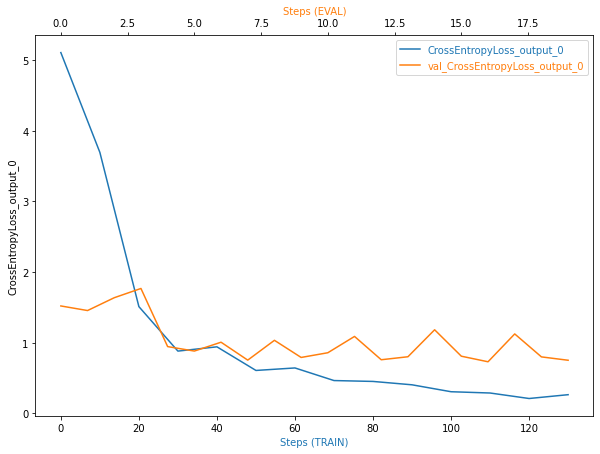

In [27]:
plot_tensor(trial, "CrossEntropyLoss_output_0")

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  

There are a few errors popping up on the debugging output - please the below list.

- Overfit: I would try implementing early stopping 
- PoorWeightInitialization: I would try to use different weight initialization techniques. 
- LossNotDecreasing: I would try implementing early stopping or using different learning rate.

In [28]:
# Display the profiler output
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
print(f"You will find the profiler report in {rule_output_path}")

! aws s3 ls {rule_output_path} --recursive
! aws s3 cp {rule_output_path} ./ --recursive

import os

# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

import IPython

IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

You will find the profiler report in s3://sagemaker-us-east-1-068969007877/pytorch-training-2022-03-04-02-02-44-492/rule-output
2022-03-04 02:17:27     451562 pytorch-training-2022-03-04-02-02-44-492/rule-output/ProfilerReport/profiler-output/profiler-report.html
2022-03-04 02:17:26     313089 pytorch-training-2022-03-04-02-02-44-492/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2022-03-04 02:17:21        603 pytorch-training-2022-03-04-02-02-44-492/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2022-03-04 02:17:21      35564 pytorch-training-2022-03-04-02-02-44-492/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2022-03-04 02:17:21       2008 pytorch-training-2022-03-04-02-02-44-492/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2022-03-04 02:17:21        339 pytorch-training-2022-03-04-02-02-44-492/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.jso

## Model Deploying

In [ ]:
# Deploy the model to an endpoint

# in case the model has already been saved, run the following
# https://sagemaker-examples.readthedocs.io/en/latest/frameworks/pytorch/get_started_mnist_deploy.html
# model = PyTorchModel(
#     entry_point="inference.py",
#     source_dir="code",
#     role=role,
#     model_data=pt_mnist_model_data,
#     framework_version="1.5.0",
#     py_version="py3",
# )

predictor=estimator.deploy(initial_instance_count=1, instance_type="ml.t2.medium") # TODO: Add your deployment configuration like instance type and number of instances

In [30]:
# Load the model using inference.py
from sagemaker.pytorch.model import PyTorchModel
model_location = 's3://sagemaker-us-east-1-068969007877/pytorch-training-220304-0058-004-4d98dc57/output/model.tar.gz'
    
estimator = PyTorchModel(model_data=model_location,
                             role=role,
                             entry_point='inference.py',
                             py_version='py3',
                             framework_version='1.5')

predictor=estimator.deploy(initial_instance_count=1, instance_type="ml.t2.medium")

-----------!

Text(0.5, 1.0, '043.Canaan_dog/Canaan_dog_03066.jpg')

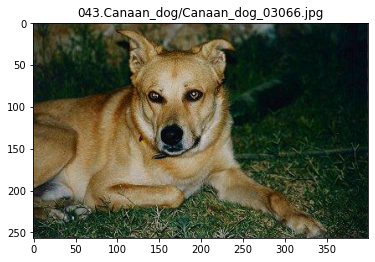

In [43]:
# Run an prediction on the endpoint
import random
import os
import numpy as np
path = 'dogImages/test/'
folders=os.listdir(path)
folder=random.choice(folders)
file = random.choice(os.listdir(path + folder))

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# Read Images
img = mpimg.imread(path + folder + '/' + file)
 
# Output Images
plt.imshow(img)
plt.title(folder + '/' + file)

In [44]:
# resize images for prediction

print('original image size', img.shape)
img = np.resize(img, (3,224,224))
from numpy import asarray
data = asarray(img)
print(type(data))
# summarize shape
print('After resizing the image has size: ', data.shape)

original image size (257, 400, 3)
<class 'numpy.ndarray'>
After resizing the image has size:  (3, 224, 224)


In [45]:
data = data.astype(np.float32)
data = np.expand_dims(data, axis=0)
data.shape

(1, 3, 224, 224)

In [46]:
response = predictor.predict(data)   # TODO: Query the endpoint
print("Raw prediction result:")
print(response)
print()

Raw prediction result:
[[1739.39697266 4287.0390625  5350.06152344 3559.07666016 3570.48803711
  1266.30517578 4299.62695312 5966.11767578 7097.42480469 6329.90869141
  5969.76074219 5442.41992188 6138.49951172 5479.10302734 3760.66845703
  6081.98144531 2601.46044922 5289.80859375 1300.46398926 2134.31958008
  3336.57788086 4166.75537109 2684.76245117  620.80987549 3232.67041016
  1591.46887207 4169.66943359 2926.92797852 3991.74829102 5844.55859375
  3500.44238281 4044.703125   4072.3190918  5536.27685547 5150.50195312
  3854.21118164 6559.40673828 6287.90771484 4642.03710938 4457.85205078
  5456.28271484 4992.74023438 4010.77734375 3789.35449219 5809.96923828
  4267.83886719 7028.48486328 5298.34716797 4599.87402344 4198.18603516
  2148.68676758 3474.86181641 5256.84619141 2876.03491211 4374.02148438
  4015.26391602 3341.01220703 3362.51000977 1920.65698242 4580.33935547
  5083.5234375  3425.27636719 4109.63183594 4452.91503906 6403.19433594
  4552.09082031 5840.35839844 5154.166015

In [47]:
n_classes = len(folders)
labeled_predictions = list(zip(range(133), response[0]))
print("Labeled predictions: ")
print(labeled_predictions)
print()

Labeled predictions: 
[(0, 1739.39697265625), (1, 4287.0390625), (2, 5350.0615234375), (3, 3559.07666015625), (4, 3570.488037109375), (5, 1266.30517578125), (6, 4299.626953125), (7, 5966.11767578125), (8, 7097.4248046875), (9, 6329.90869140625), (10, 5969.7607421875), (11, 5442.419921875), (12, 6138.49951171875), (13, 5479.10302734375), (14, 3760.66845703125), (15, 6081.9814453125), (16, 2601.46044921875), (17, 5289.80859375), (18, 1300.4639892578125), (19, 2134.319580078125), (20, 3336.577880859375), (21, 4166.75537109375), (22, 2684.762451171875), (23, 620.8098754882812), (24, 3232.67041015625), (25, 1591.4688720703125), (26, 4169.66943359375), (27, 2926.927978515625), (28, 3991.748291015625), (29, 5844.55859375), (30, 3500.4423828125), (31, 4044.703125), (32, 4072.319091796875), (33, 5536.27685546875), (34, 5150.501953125), (35, 3854.211181640625), (36, 6559.40673828125), (37, 6287.90771484375), (38, 4642.037109375), (39, 4457.85205078125), (40, 5456.28271484375), (41, 4992.74023437

In [48]:
labeled_predictions.sort(key=lambda label_and_prob: 1.0 - label_and_prob[1])
print("Most likely answer: {}".format(labeled_predictions[0]))

Most likely answer: (8, 7097.4248046875)


In [49]:
# Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()